In [1]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
#|hide
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
#|default_exp agents.dqn.basic

In [1]:
#|export
# Python native modules
import os
from collections import deque
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch.utils.data.dataloader_experimental import DataLoader2
from torch.utils.data.datapipes._typing import _DataPipeMeta, _IterDataPipeMeta
# Local modules
import torch
from torch.nn import *
import torch.nn.functional as F
from torch.optim import *
from fastai.torch_basics import *
from fastai.torch_core import *

from fastrl.core import *
from fastrl.agents.core import *
from fastrl.pipes.core import *
from fastrl.fastai.data.block import *
from fastrl.memory.experience_replay import *

# DQN Basic
> Core DQN modules, pipes, and tooling

## Agent

In [5]:
#|export
class DQN(Module):
    def __init__(self,state_sz:int,action_sz:int,hidden=512):
        self.layers=Sequential(
            Linear(state_sz,hidden),
            ReLU(),
            Linear(hidden,action_sz),
        )
    def forward(self,x): return self.layers(x)


In [6]:
#|export
class BasicModelForwarder(dp.iter.IterDataPipe):
    "Takes input from `source_datapipe` and pushes through the agent bases model assuming there is only one model field."
    def __init__(self,source_datapipe): 
        self.source_datapipe = source_datapipe
        self.agent_base = find_agent_base(self.source_datapipe)
    
    def __iter__(self):
        for state in self.source_datapipe:
            if len(state.shape)==1:
                state.unsqueeze_(0)
            yield self.agent_base.model(state)

Check that the 1x4 tensor assuccessfully pushes through the model can get expected outputs...

In [7]:
# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the agent
agent = AgentBase(model)
agent = BasicModelForwarder(agent)
agent = AgentHead(agent)

In [8]:
for action in agent([tensor([1,2,3,4]).float()]):
    print(action)

tensor([[-0.2909, -1.0357]], grad_fn=<AddmmBackward0>)


In [9]:
#|export
class StepFieldSelector(dp.iter.IterDataPipe):
    "Grabs `field` from `source_datapipe` to push to the rest of the pipeline."
    def __init__(self,
         source_datapipe, # datapipe whose next(source_datapipe) -> `StepType`
         field='state' # A field in `StepType` to grab
        ): 
        # TODO: support multi-fields
        self.source_datapipe = source_datapipe
        self.field = field
    
    def __iter__(self):
        for step in self.source_datapipe:
            if not issubclass(step.__class__,StepType):
                raise Exception(f'Expected typing.NamedTuple object got {type(step)}\n{step}')
            yield getattr(step,self.field)

Check that using `StepFieldSelector`, we can grab the `state` field from the `Simplestep` to push through the model...

In [10]:
agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = AgentHead(agent)

for action in agent([SimpleStep.random(state=tensor([1.,2.,3.,4.]))]):
    print(action)

tensor([[-0.2909, -1.0357]], grad_fn=<AddmmBackward0>)


In [11]:
#|export
class ArgMaxer(dp.iter.IterDataPipe):
    debug=False
    
    "Given input `Tensor` from `source_datapipe` returns a tensor of same shape with argmax set to 1."
    def __init__(self,source_datapipe,axis=1): 
        self.source_datapipe = source_datapipe
        self.axis = axis
        
    def debug_display(self,step,idx):
        print(f'Step: {step}\n{idx}')
    
    def __iter__(self) -> torch.LongTensor:
        for step in self.source_datapipe:
            if not issubclass(step.__class__,Tensor):
                raise Exception(f'Expected Tensor to take the argmax, got {type(step)}\n{step}')
            # Might want to support simple tuples also depending on if we are processing multiple fields.
            idx = torch.argmax(step,axis=self.axis).reshape(-1,1)
            step[:] = 0
            if self.debug: self.debug_display(step,idx)
            step.scatter_(1,idx,1)
            yield step.long()
            

In [12]:
agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = ArgMaxer(agent)
agent = AgentHead(agent)

for action in agent([SimpleStep.random(state=tensor([[1.,2.,3.,4.]]))]):
    print(action)

tensor([[1, 0]])


In [13]:
#|export
class EpsilonSelector(dp.iter.IterDataPipe):
    debug=False
    "Given input `Tensor` from `source_datapipe`."
    def __init__(self,
            source_datapipe, # a datapipe whose next(source_datapipe) -> `Tensor` 
            min_epsilon:float=0.2, # The minimum epsilon to drop to
            # The max/starting epsilon if `epsilon` is None and used for calculating epislon decrease speed.
            max_epsilon:float=1, 
            # Determines how fast the episilon should drop to `min_epsilon`. This should be the number
            # of steps that the agent was run through.
            max_steps:int=100,
            # The starting epsilon
            epsilon:float=None,
            # Based on the `base_agent.model.training`, by default no decrement or step tracking will
            # occur during validation steps.
            decrement_on_val:bool=False,
            # Based on the `base_agent.model.training`, by default random actions will not be attempted
            select_on_val:bool=False,
            # Also return the mask that, where True, the action should be randomly selected.
            ret_mask:bool=False
        ): 
        self.source_datapipe = source_datapipe
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.max_steps = max_steps
        self.epsilon = epsilon
        self.decrement_on_val = decrement_on_val
        self.select_on_val = select_on_val
        self.ret_mask = ret_mask
        self.agent_base = find_agent_base(self.source_datapipe)
        self.step = 0
    
    def __iter__(self):
        for action in self.source_datapipe:
            # TODO: Support tuples of actions also
            if not issubclass(action.__class__,Tensor):
                raise Exception(f'Expected Tensor, got {type(action)}\n{action}')
            if action.dtype!=torch.int64:
                raise ValueError(f'Expected Tensor of dtype int64, got: {action.dtype} from {self.source_datapipe}')
                
            if self.agent_base.model.training or self.decrement_on_val:
                self.step+=1
                
            self.epsilon=max(self.min_epsilon,self.max_epsilon-self.step/self.max_steps)
            # Add a batch dim if missing
            if len(action.shape)==1: action.unsqueeze_(0)
            mask = None
            if self.agent_base.model.training or self.select_on_val:
                # Given N(action.shape[0]) actions, select the ones we want to randomly assign... 
                mask = torch.rand(action.shape[0],)<self.epsilon
                # Get random actions as their indexes
                rand_action_idxs = torch.LongTensor(int(mask.sum().long()),).random_(action.shape[1])
                # If the input action is [[0,1],[1,0]] and...
                # If mask is [True,False] and...
                # if rand_action_idxs is [0]
                # the action[mask] will have [[1,0]] assigned to it resulting in... 
                # an action with [[1,0],[1,0]]
                # print(action.shape[1])
                if self.debug: print(f'Mask: {mask}\nRandom Actions: {rand_action_idxs}\nPre-random Actions: {action}')
                action[mask] = F.one_hot(rand_action_idxs,action.shape[1])
            
            yield ((action,mask) if self.ret_mask else action)

Check that when `min_epsilon=1`, that the actions have 100% likihood of randomness applied 
(even though some might not change due to the random action matching the chosen action). Check that this 
works on a large batch of `200 steps`...

In [14]:
agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = ArgMaxer(agent)
selector = EpsilonSelector(agent,min_epsilon=1,ret_mask=True)
agent = AgentHead(selector)

for action,mask in agent([SimpleStep.random(state=tensor([[1.,2.,3.,4.]]*200))]):
    test_eq(mask.sum(),200)
    test_ne(action.sum(0)[0],200) # Only some of the actions should 1
    test_ne(action.sum(0)[1],0) # Only some of the actions should be 0
    test_eq(selector.epsilon,1)
    test_eq(selector.step,1)

Check that when `min_epsilon=1`, that the actions have 100% likihood of randomness applied 
(even though some might not change due to the random action matching the chosen action). Check that this 
works on single batches over `200 steps`...

In [15]:
ArgMaxer.debug=False

In [16]:
agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = ArgMaxer(agent,axis=1)
selector = EpsilonSelector(agent,min_epsilon=1,ret_mask=True)
agent = AgentHead(selector)

actions = None
for i in range(200):
    for action,mask in agent([SimpleStep.random(state=tensor([[1.,2.,3.,4.]]))]):
        test_eq(mask.sum(),1)
        if actions is None: actions = action
        else:               actions = torch.vstack((actions,action))
test_ne(actions.sum(0)[0],200) # Only some of the actions should 1
test_ne(actions.sum(0)[1],0) # Only some of the actions should be 0
test_eq(selector.epsilon,1)
test_eq(selector.step,200)

Check that when `min_epsilon=0 and max_epsilon=0`, that the actions have 0% likihood of randomness applied. Check that this 
works on a large batch of `200 steps`...

In [17]:
agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = ArgMaxer(agent)
selector = EpsilonSelector(agent,min_epsilon=0,max_epsilon=0,ret_mask=True)
agent = AgentHead(selector)

for action,mask in agent([SimpleStep.random(state=tensor([[1.,2.,3.,4.]]*200))]):
    test_eq(mask.sum(),0)
    test_eq(action.sum(0)[0],200) # All the "left" actions should be 1
    test_eq(action.sum(0)[1],0) # All the "right" actions should be 0
    test_eq(selector.epsilon,0)
    test_eq(selector.step,1)

Check that when `min_epsilon=0 and max_epsilon=0`, that the actions have 0% likihood of randomness applied. Check that this 
works on single batches over `200 steps`...

In [18]:
agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = ArgMaxer(agent)
selector = EpsilonSelector(agent,min_epsilon=0,max_epsilon=0,ret_mask=True)
agent = AgentHead(selector)

actions = None
for i in range(200):
    for action,mask in agent([SimpleStep.random(state=tensor([[1.,2.,3.,4.]]))]):
        test_eq(mask.sum(),0)
        if actions is None: actions = action
        else:               actions = torch.vstack((actions,action))
test_eq(actions.sum(0)[0],200) # All the "left" actions should be 1
test_eq(actions.sum(0)[1],0) # All the "right" actions should be 0
test_eq(selector.epsilon,0)
test_eq(selector.step,200)

Check that when `min_epsilon=0 and max_epsilon=1`, the actions should become less random
as the steps go on. Check that this works on a large batch of `200 steps`...

`epislon` should be 0 at the end of this...

In [19]:
agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = ArgMaxer(agent)
selector = EpsilonSelector(agent,min_epsilon=0,max_epsilon=1,max_steps=100,ret_mask=True)
agent = AgentHead(selector)

actions = None
masks = None
epsilons = None
for i in range(200):
    for action,mask in agent([SimpleStep.random(state=tensor([[1.,2.,3.,4.]]*200))]):
        if actions is None: actions = action
        else:               actions = torch.vstack((actions,action))
        if masks is None: masks = mask
        else:             masks = torch.hstack((masks,mask))
        if epsilons is None: epsilons = tensor([selector.epsilon])
        else:                epsilons = torch.hstack((epsilons,tensor([selector.epsilon])))
        
test_ne(masks[:((200*200)//2)].sum(),200) # We do not expect this to equal a perfect 200...
test_ne(masks[:((200*200)//2)].sum(),0)   # ... but we also dont expect it to be 0
assert 1000<masks[:((200*200)//2)].sum()<10_000,\
        """We expect this to be somewhere between 1000 and 10,000, generally in the 9000 range since 
           for 200 steps, we are running 200 inputs"""
test_eq(masks[((200*200)//2):].sum(),0) # We fully expect this to be 0 after the half way point
test_ne(actions.sum(0)[0],200) # All the "left" generally shouldnt be 1
test_ne(actions.sum(0)[1],0) # All the "right"  generally shouldnt be 0
test_eq(selector.epsilon,0)
test_eq(selector.step,200)
# Since the max steps are 100, and we go for 200 steps, the first 100 epislon entries shouldnt be 0
test_ne(epsilons[:100].sum(),0) 
# In fact the first 100 should sum up to somewhere between 40 and 50. (expected 49.5)
test_eq(40<epsilons[:100].sum()<50,True) 
# Everything after 100 should be 0
test_eq(epsilons[100:].sum(),0)

Check that when `min_epsilon=0 and max_epsilon=0`, that the actions have 0% likihood of randomness applied. Check that this 
works on single batches over `200 steps`...

In [20]:
agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = ArgMaxer(agent)
selector = EpsilonSelector(agent,min_epsilon=0,max_epsilon=1,max_steps=100,ret_mask=True)
agent = AgentHead(selector)

actions = None
masks = None
epsilons = None
for i in range(200):
    for action,mask in agent([SimpleStep.random(state=tensor([[1.,2.,3.,4.]]))]):
        if actions is None: actions = action
        else:               actions = torch.vstack((actions,action))
        if masks is None: masks = mask
        else:             masks = torch.hstack((masks,mask))
        if epsilons is None: epsilons = tensor([selector.epsilon])
        else:                epsilons = torch.hstack((epsilons,tensor([selector.epsilon])))
        
test_ne(masks[:(200//2)].sum(),200) # We do not expect this to equal a perfect 200...
test_ne(masks[:(200//2)].sum(),0)   # ... but we also dont expect it to be 0
assert 40<masks[:(200//2)].sum()<60,'We expect this to be somewhere between 60, generally in the ~50 range'
test_eq(masks[(200//2):].sum(),0) # We fully expect this to be 0 after the half way point
test_ne(actions.sum(0)[0],200) # All the "left" generally shouldnt be 1
test_ne(actions.sum(0)[1],0) # All the "right"  generally shouldnt be 0
test_eq(selector.epsilon,0)
test_eq(selector.step,200)
# Since the max steps are 100, and we go for 200 steps, the first 100 epislon entries shouldnt be 0
test_ne(epsilons[:100].sum(),0) 
# In fact the first 100 should sum up to somewhere between 40 and 50. (expected 49.5)
test_eq(40<epsilons[:100].sum()<50,True) 
# Everything after 100 should be 0
test_eq(epsilons[100:].sum(),0)

## Data

In [21]:
from fastrl.envs.gym import *
from fastrl.fastai.data.block import *

In [22]:
#|export
class ArgMaxer(dp.iter.IterDataPipe):
    debug=False
    
    "Given input `Tensor` from `source_datapipe` returns a tensor of same shape with argmax set to 1."
    def __init__(self,source_datapipe,axis=1,only_idx=False): 
        self.source_datapipe = source_datapipe
        self.axis = axis
        self.only_idx = only_idx
        
    def debug_display(self,step,idx):
        print(f'Step: {step}\n{idx}')
    
    def __iter__(self) -> torch.LongTensor:
        for step in self.source_datapipe:
            if not issubclass(step.__class__,Tensor):
                raise Exception(f'Expected Tensor to take the argmax, got {type(step)}\n{step}')
            # Might want to support simple tuples also depending on if we are processing multiple fields.
            idx = torch.argmax(step,axis=self.axis).reshape(-1,1)
            if self.only_idx: 
                yield idx.long()
                continue
            step[:] = 0
            if self.debug: self.debug_display(step,idx)
            step.scatter_(1,idx,1)
            yield step.long()
            

In [23]:
#|export
class NumpyConverter(dp.iter.IterDataPipe):
    debug=False
    
    "Given input `Tensor` from `source_datapipe` returns a numpy array of same shape with argmax set to 1."
    def __init__(self,source_datapipe): 
        self.source_datapipe = source_datapipe
        
    def debug_display(self,step,idx):
        print(f'Step: {step}\n{idx}')
    
    def __iter__(self) -> torch.LongTensor:
        for step in self.source_datapipe:
            if not issubclass(step.__class__,Tensor):
                raise Exception(f'Expected Tensor to  convert to numpy, got {type(step)}\n{step}')
            if self.debug: self.debug_display(step,idx)
            yield step.numpy()
            

In [24]:
#|export
class PyPrimativeConverter(dp.iter.IterDataPipe):
    debug=False
    
    "Given input `Tensor` from `source_datapipe` returns a numpy array of same shape with argmax set to 1."
    def __init__(self,source_datapipe,remove_batch_dim=True): 
        self.source_datapipe = source_datapipe
        self.remove_batch_dim = remove_batch_dim
        
    def debug_display(self,step): print(f'Step: {step}')
    
    def __iter__(self) -> Union[float,bool,int]:
        for step in self.source_datapipe:
            if not issubclass(step.__class__,(np.ndarray)):
                raise Exception(f'Expected list or np.ndarray to  convert to python primitive, got {type(step)}\n{step}')
            if self.debug: self.debug_display(step)
            
            if len(step)>1 or len(step)==0:
                raise Exception(f'`step` from {self.source_datapipe} needs to be len 1, not {len(step)}')
            else:
                step = step[0]
                
            if np.issubdtype(step.dtype,np.integer):
                yield int(step)
            elif np.issubdtype(step.dtype,np.floating):
                yield float(step)
            elif np.issubdtype(step.dtype,np.bool8):
                yield bool(step)
            else:
                raise Exception(f'`step` from {self.source_datapipe} must be one of the 3 python types: bool,int,float, not {step.dtype}')

In [25]:
pipe = PyPrimativeConverter([np.array([0.5])])
L(pipe)

(#1) [0.5]

In [26]:
pipe = PyPrimativeConverter([np.array([1])])
L(pipe)

(#1) [1]

In [27]:
pipe = PyPrimativeConverter([np.array([True])])
L(pipe)

(#1) [True]

In [28]:
# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)

agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = ArgMaxer(agent)
selector = EpsilonSelector(agent,min_epsilon=0,max_epsilon=1,max_steps=100)
agent = ArgMaxer(selector,only_idx=True)
agent = NumpyConverter(agent)
agent = PyPrimativeConverter(agent)
agent = AgentHead(agent)

## Training

In [36]:
#|export
class LearnerBase(dp.iter.IterDataPipe):
    def __init__(self,
            model:Module, # The base NN that we getting raw action values out of.
            dls:List[DataLoader2], # The dataloaders to read data from for training
            loss_func=None, # The loss function to use
            opt=None, # The optimizer to use
            # LearnerBase will yield each dl individually by default. If `zipwise=True`
            # next() will be called on `dls` and will `yield next(dl1),next(dl2),next(dl1)...`
            zipwise:bool=False
    ):
        self.loss_func = loss_func
        self.opt = opt
        self.model = model
        self.iterable = dls
        self.zipwise = zipwise
        self.learner_base = self
        self.batches = find_pipe_instance(dls[0].dataset,dp.iter.Cycler).count

    def __iter__(self):
        dls = [iter(dl) for dl in self.iterable]
        exhausted = []
        if self.zipwise:
            yield from [next(dl) for i,dl in enumerate(dls) if i not in exhausted]
        else:
            while not exhausted:
                for i,dl in enumerate(dls): 
                    while i not in exhausted:
                        try:
                            yield next(dl)
                        except StopIteration:
                            exhausted.append(i)

In [47]:
#|export
def is_learner_base(pipe): return isinstance(pipe,LearnerBase)

def find_learner_base(pipe):
    "Basically just find_pipes+is_learner_base with exception handling"
    learner_base = find_pipes(pipe,is_learner_base)
    if not learner_base:
        raise Exception('`LearnerBase` must be at the start of the pipeline, but it seems to be missing.')
    return learner_base[0]

class LearnerHead(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe):
        self.source_datapipe = source_datapipe
        self.learner_base = find_learner_base(self.source_datapipe)

    def __iter__(self): yield from self.source_datapipe
    
    def fit(self,epochs):
        epocher = find_pipes(self,is_epocher)[0]
        epocher.epochs = epochs
        
        for iteration in self: 
            pass

In [46]:
#|export
def is_epocher(pipe): return isinstance(pipe,EpocherCollector)

from fastrl.loggers.core import *
def is_epocher(pipe): return isinstance(pipe,EpocherCollector)

class EpocherCollector(dp.iter.IterDataPipe):
    def __init__(self,
            source_datapipe,
            logger_bases:List[LoggerBase]=None # `LoggerBase`s that we want to send metrics to
        ):
        self.source_datapipe = source_datapipe
        self.main_queues = [o.main_queue for o in logger_bases] if logger_bases is not None else None
        self.iteration_started = False
        self.epochs = 0
        self.epoch = 0

    def __iter__(self): 
        if self.main_queues is not None and not self.iteration_started:
            for q in self.main_queues: q.put(Record('epoch',None))
            self.iteration_started = True
            
        for i in range(self.epochs): 
            self.epoch = i
            if self.main_queues is not None:
                for q in self.main_queues: q.put(Record('epoch',self.epoch))
            yield from self.source_datapipe   
        
class BatchCollector(dp.iter.IterDataPipe):
    def __init__(self,
            source_datapipe,
            logger_bases:List[LoggerBase], # `LoggerBase`s that we want to send metrics to
            batches:Optional[int]=None
        ):
        self.source_datapipe = source_datapipe
        self.main_queues = [o.main_queue for o in logger_bases] if logger_bases is not None else None
        self.iteration_started = False
        self.batches = ifnone(
            batches,
            find_pipe_instance(self.source_datapipe,pipe_cls=LearnerBase).batches
        )
        self.batch = 0

    def __iter__(self): 
        if self.main_queues is not None and not self.iteration_started:
            for q in self.main_queues: q.put(Record('batch',None))
            self.iteration_started = True
            
        self.batch = 0
        for batch,record in enumerate(self.source_datapipe): 
            yield record
            self.batch = batch
            if self.main_queues is not None:
                for q in self.main_queues: q.put(Record('batch',batch))

In [51]:
#|export
class ProgressBarLogger(LoggerBase):
    def __init__(self,
                 # This does not need to be immediately set since we need the `LogCollectors` to 
                 # first be able to reference its queues.
                 source_datapipe=None, 
                 # For automatic pipe attaching, we can designate which pipe this should be
                 # referneced for information on which epoch we are on
                 epoch_on_pipe:dp.iter.IterDataPipe=EpocherCollector,
                 # For automatic pipe attaching, we can designate which pipe this should be
                 # referneced for information on which batch we are on
                 batch_on_pipe:dp.iter.IterDataPipe=BatchCollector
                ):
        self.source_datapipe = source_datapipe
        self.main_queue = Queue()
        self.epoch_on_pipe = epoch_on_pipe
        self.batch_on_pipe = batch_on_pipe
        
        self.collector_keys = None
        self.attached_collectors = None
    
    def dequeue(self): 
        while not self.main_queue.empty(): yield self.main_queue.get()
        
    def __iter__(self):
        epocher = find_pipe_instance(self,self.epoch_on_pipe)
        batcher = find_pipe_instance(self,self.batch_on_pipe)
        mbar = master_bar(range(epocher.epochs)) 
        pbar = progress_bar(range(batcher.batches),parent=mbar,leave=False)

        mbar.update(0)
        for i,record in enumerate(self.source_datapipe):
            if i==0:
                self.attached_collectors = {o.name:o.value for o in self.dequeue()}
                mbar.write(self.attached_collectors, table=True)
                self.collector_keys = list(self.attached_collectors)
                    
            attached_collectors = {o.name:o.value for o in self.dequeue()}
            
            if attached_collectors:
                self.attached_collectors = merge(self.attached_collectors,attached_collectors)
            
            if 'batch' in attached_collectors:
                pbar.update(attached_collectors['batch'])
                
            if 'epoch' in attached_collectors:
                mbar.update(attached_collectors['epoch'])
                collector_values = {k:self.attached_collectors.get(k,None) for k in self.collector_keys}
                mbar.write([f'{l:.6f}' if isinstance(l, float) else str(l) for l in collector_values.values()], table=True)
            

            yield record

        attached_collectors = {o.name:o.value for o in self.dequeue()}
        if attached_collectors: self.attached_collectors = merge(self.attached_collectors,attached_collectors)

        collector_values = {k:self.attached_collectors.get(k,None) for k in self.collector_keys}
        mbar.write([f'{l:.6f}' if isinstance(l, float) else str(l) for l in collector_values.values()], table=True)

        pbar.on_iter_end()
        mbar.on_iter_end()
            

In [52]:
# # Setup Loggers

logger_base = ProgressBarLogger(
)

In [53]:
#|export
class EpsilonCollector(LogCollector):
    def __iter__(self):
        for q in self.main_queues: q.put(Record('epsilon',None))
        for action in self.source_datapipe:
            for q in self.main_queues: 
                q.put(Record('epsilon',self.source_datapipe.epsilon))
            yield action

In [54]:
# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)

agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = ArgMaxer(agent)
selector = EpsilonSelector(agent,min_epsilon=0,max_epsilon=1,max_steps=100)
agent = EpsilonCollector(selector,[logger_base])
agent = ArgMaxer(agent,only_idx=True)
agent = NumpyConverter(agent)
agent = PyPrimativeConverter(agent)
agent = AgentHead(agent)

In [55]:
block = DataBlock(
    blocks = GymTransformBlock(agent)
)
dls = L(block.dataloaders(['CartPole-v1']*1,n=10,bs=1))

In [56]:
list(dls[0])

[[SimpleStep(state=tensor([[ 0.0418, -0.0168,  0.0160, -0.0054]]), action=tensor([1.]), next_state=tensor([[ 0.0415,  0.1781,  0.0159, -0.2930]]), terminated=tensor([False]), truncated=tensor([False]), reward=tensor([1.]), total_reward=tensor([1.]), env_id=tensor([139899300056528]), proc_id=tensor([315]), step_n=tensor([1]), episode_n=tensor([1]), image=tensor([[0.]]))],
 [SimpleStep(state=tensor([[ 0.0415,  0.1781,  0.0159, -0.2930]]), action=tensor([0.]), next_state=tensor([[ 0.0450, -0.0172,  0.0100,  0.0046]]), terminated=tensor([False]), truncated=tensor([False]), reward=tensor([1.]), total_reward=tensor([2.]), env_id=tensor([139899300056528]), proc_id=tensor([315]), step_n=tensor([2]), episode_n=tensor([1]), image=tensor([[0.]]))],
 [SimpleStep(state=tensor([[ 0.0450, -0.0172,  0.0100,  0.0046]]), action=tensor([1.]), next_state=tensor([[ 0.0447,  0.1777,  0.0101, -0.2849]]), terminated=tensor([False]), truncated=tensor([False]), reward=tensor([1.]), total_reward=tensor([3.]), en

In [57]:
#|export
class QCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,discount=0.99,nsteps=1):
        self.source_datapipe = source_datapipe
        self.discount = discount
        self.nsteps = nsteps
        self.learner = find_learner_base(self.source_datapipe)
        
    def __iter__(self):
        for batch in self.source_datapipe:
            self.learner.done_mask = batch.terminated.reshape(-1,)
            
            self.learner.next_q = self.learner.model(batch.next_state)
            # print(self.learner.next_q,self.learner.done_mask)
            self.learner.next_q = self.learner.next_q.max(dim=1).values.reshape(-1,1)
            self.learner.next_q[self.learner.done_mask] = 0 #xb[done_mask]['reward']
            self.learner.targets = batch.reward+self.learner.next_q*(self.discount**self.nsteps)
            self.learner.pred = self.learner.model(batch.state)
            
            t_q=self.learner.pred.clone()
            t_q.scatter_(1,batch.action.long(),self.learner.targets)
            
            self.learner.loss_grad = self.learner.loss_func(self.learner.pred, t_q)
            yield batch
            
class ModelLearnCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe):
        self.source_datapipe = source_datapipe
        self.learner = find_learner_base(self.source_datapipe)
        
    def __iter__(self):
        for batch in self.source_datapipe:
            self.learner.loss_grad.backward()
            self.learner.opt.step()
            self.learner.opt.zero_grad()
            self.learner.loss = self.learner.loss_grad.clone()
            yield self.learner.loss

In [58]:
#|export
class StepBatcher(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe):
        "Converts multiple `StepType` into a single `StepType` with the fields concated."
        self.source_datapipe = source_datapipe
        
    def __iter__(self):
        for batch in self.source_datapipe:
            # print(batch)
            cls = batch[0].__class__
            yield cls(
                **{
                    fld:torch.vstack(tuple(getattr(step,fld) for step in batch)) for fld in cls._fields
                }
            )

In [59]:
#|export
class EpisodeCollector(LogCollector):
    def __iter__(self):
        for q in self.main_queues: q.put(Record('episode',None))
        for steps in self.source_datapipe:
            if isinstance(steps,dp.DataChunk):
                for step in steps:
                    for q in self.main_queues: q.put(Record('episode',step.episode_n.detach().numpy()[0]))
            else:
                for q in self.main_queues: q.put(Record('episode',steps.episode_n.detach().numpy()[0]))
            yield steps

In [60]:
#|export
class LossCollector(LogCollector):
    def __init__(self,
         source_datapipe, # The parent datapipe, likely the one to collect metrics from
         logger_bases:List[LoggerBase] # `LoggerBase`s that we want to send metrics to
        ):
        self.source_datapipe = source_datapipe
        self.main_queues = [o.main_queue for o in logger_bases]
        self.learner = find_learner_base(self.source_datapipe)
        
    def __iter__(self):
        for q in self.main_queues: q.put(Record('loss',None))
        for steps in self.source_datapipe:
            for q in self.main_queues: q.put(Record('loss',self.learner.loss.detach().numpy()))
            yield steps

In [61]:
#|export
class RollingTerminatedRewardCollector(LogCollector):
    def __init__(self,
         source_datapipe, # The parent datapipe, likely the one to collect metrics from
         logger_bases:List[LoggerBase], # `LoggerBase`s that we want to send metrics to
         rolling_length:int=100
        ):
        self.source_datapipe = source_datapipe
        self.main_queues = [o.main_queue for o in logger_bases]
        self.rolling_rewards = deque([],maxlen=rolling_length)
        
    def step2terminated(self,step): return bool(step.terminated)
    def __iter__(self):
        for q in self.main_queues: q.put(Record('rolling_reward',None))
        for steps in self.source_datapipe:
            if isinstance(steps,dp.DataChunk):
                for step in steps:
                    if self.step2terminated(step):
                        self.rolling_rewards.append(step.total_reward.detach().numpy()[0])
                        for q in self.main_queues: q.put(Record('rolling_reward',np.average(self.rolling_rewards)))
            elif self.step2terminated(steps):
                self.rolling_rewards.append(steps.total_reward.detach().numpy()[0])
                for q in self.main_queues: q.put(Record('rolling_reward',np.average(self.rolling_rewards)))
            yield steps

In [62]:
from fastprogress import fastprogress

In [66]:
# Setup Loggers
logger_base = ProgressBarLogger()

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the Agent
agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = ArgMaxer(agent)
selector = EpsilonSelector(agent,min_epsilon=0.02,max_epsilon=1,max_steps=10000)
agent = EpsilonCollector(selector,[logger_base])
agent = ArgMaxer(agent,only_idx=True)
agent = NumpyConverter(agent)
agent = PyPrimativeConverter(agent)
agent = AgentHead(agent)
# Setup the DataBlock
block = DataBlock(
    blocks = GymTransformBlock(agent=agent)
)
dls = L(block.dataloaders(['CartPole-v1']*1,n=1000,bs=1))
# Setup the Learner
learner = LearnerBase(model,dls,loss_func=MSELoss(),opt=AdamW(model.parameters(),lr=0.005))
learner = BatchCollector(learner,[logger_base])
learner = EpocherCollector(learner,[logger_base])
learner = logger_base.connect_source_datapipe(learner)
learner = RollingTerminatedRewardCollector(learner,[logger_base])
learner = EpisodeCollector(learner,[logger_base])
learner = ExperienceReplay(learner,bs=128,max_sz=10000)
learner = StepBatcher(learner)
learner = QCalc(learner)
learner = ModelLearnCalc(learner)
learner = LossCollector(learner,[logger_base])
learner = LearnerHead(learner)

learner.fit(3)
# learner.fit(30)

loss,episode,rolling_reward,epoch,batch,epsilon
0.294591,41,24.8,1,999,0.899900
0.23077747,79,25.602564,2,999,0.799900
0.24024382,112,27.33,3,999,0.699900
0.23441581,135,32.15,4,999,0.599900
0.24172296,155,36.69,5,999,0.499900
0.25344092,170,42.62,6,999,0.399900
0.284737,181,49.37,7,999,0.299900
0.30140695,190,56.82,8,999,0.199900
0.3079363,197,64.36,9,999,0.099900
0.2763259,201,72.26,10,999,0.020000


In [67]:
from fastrl.loggers.jupyter_visualizers import *

In [68]:
model.eval()

DQN(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [69]:
import pandas as pd
from fastrl.pipes.core import *
from fastrl.envs.gym import GymTypeTransform,GymStepper

def gym_pipe_base(envs,total_steps,seed=0):
    pipe = dp.map.Mapper(envs)
    pipe = TypeTransformLoop(pipe,[GymTypeTransform])
    pipe = dp.iter.MapToIterConverter(pipe)
    pipe = dp.iter.InMemoryCacheHolder(pipe)
    pipe = pipe.cycle(count=total_steps)
    pipe = GymStepper(pipe,agent=agent,seed=seed,include_images=True)
    return pipe

In [70]:
%matplotlib inline

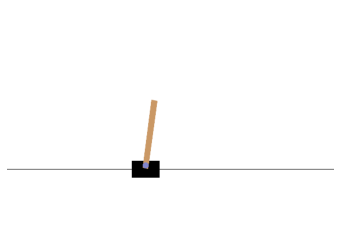

In [73]:

video_logger = SimpleJupyterVideoPlayer()

pipe = gym_pipe_base(['CartPole-v1'],1000,seed=None)
pipe = ImageCollector(pipe,[video_logger])

pipe = video_logger.connect_source_datapipe(pipe)

L(pipe);

In [82]:
# Setup Loggers
logger_base = ProgressBarLogger()

# Setup up the core NN
torch.manual_seed(0)
model = DQN(8,4)
# Setup the Agent
agent = AgentBase(model)
agent = StepFieldSelector(agent,field='state')
agent = BasicModelForwarder(agent)
agent = ArgMaxer(agent)
selector = EpsilonSelector(agent,min_epsilon=0.02,max_epsilon=1,max_steps=10000)
agent = EpsilonCollector(selector,[logger_base])
agent = ArgMaxer(agent,only_idx=True)
agent = NumpyConverter(agent)
agent = PyPrimativeConverter(agent)
agent = AgentHead(agent)
# Setup the DataBlock
block = DataBlock(
    blocks = GymTransformBlock(agent=agent)
)
dls = L(block.dataloaders(['LunarLander-v2']*1,n=1000,bs=1))
# Setup the Learner
learner = LearnerBase(model,dls,loss_func=MSELoss(),opt=AdamW(model.parameters(),lr=0.005))
learner = BatchCollector(learner,[logger_base])
learner = EpocherCollector(learner,[logger_base])
learner = logger_base.connect_source_datapipe(learner)
learner = RollingTerminatedRewardCollector(learner,[logger_base])
learner = EpisodeCollector(learner,[logger_base])
learner = ExperienceReplay(learner,bs=128,max_sz=10000)
learner = StepBatcher(learner)
learner = QCalc(learner)
learner = ModelLearnCalc(learner)
learner = LossCollector(learner,[logger_base])
learner = LearnerHead(learner)

learner.fit(3)
# learner.fit(30)

loss,episode,rolling_reward,epoch,batch,epsilon
1.5962886,10,-236.47035,1,999,0.899900
2.295194,20,-174.32756,2,999,0.799900
1.3210166,29,-172.74147,3,999,0.699900
2.0403426,38,-155.03424,4,999,0.599900
0.4872072,45,-147.71843,5,999,0.499900
4.567928,50,-144.54634,6,999,0.399900
0.5700434,53,-143.87135,7,999,0.299900
0.61638325,56,-139.21907,8,999,0.199900
0.7877886,60,-131.72797,9,999,0.099900
0.2660519,61,-132.82907,10,999,0.020000


In [83]:
import pandas as pd
from fastrl.pipes.core import *
from fastrl.envs.gym import GymTypeTransform,GymStepper

def gym_pipe_base(envs,total_steps,seed=0):
    pipe = dp.map.Mapper(envs)
    pipe = TypeTransformLoop(pipe,[GymTypeTransform])
    pipe = dp.iter.MapToIterConverter(pipe)
    pipe = dp.iter.InMemoryCacheHolder(pipe)
    pipe = pipe.cycle(count=total_steps)
    pipe = GymStepper(pipe,agent=agent,seed=seed,include_images=True)
    return pipe

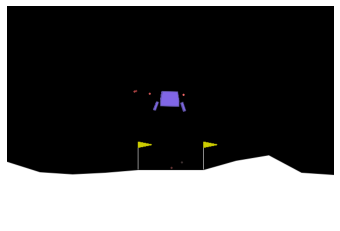

In [85]:

video_logger = SimpleJupyterVideoPlayer()

pipe = gym_pipe_base(['LunarLander-v2'],1000,seed=None)
pipe = ImageCollector(pipe,[video_logger])

pipe = video_logger.connect_source_datapipe(pipe)

L(pipe);

In [ ]:
#|hide
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()